## Лабораторная работа 6. Отбор признаков

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
df=pd.read_csv('CO2_emission.csv')
cols_drop = ['Model_Year','Make','Model', 'Transmission', 'Vehicle_Class']
df = df.drop(columns=cols_drop)
df['Категория'] = pd.cut(df['Smog_Level'], bins=[0, 3, 7], labels=[0, 1]).astype(int)
df = df.drop(columns=['Smog_Level'])

In [26]:
X=df.iloc[:,:6]
y=df.iloc[:,6]
X,y

(     Engine_Size  Cylinders  Fuel_Consumption_in_City(L/100 km)  \
 0            2.4          4                                 9.9   
 1            3.5          6                                11.1   
 2            2.0          4                                11.0   
 3            2.0          4                                11.3   
 4            2.0          4                                11.2   
 ..           ...        ...                                 ...   
 930          2.0          4                                10.7   
 931          2.0          4                                11.1   
 932          2.0          4                                11.7   
 933          2.0          4                                11.5   
 934          2.0          4                                12.1   
 
      Fuel_Consumption_in_City_Hwy(L/100 km)  Fuel_Consumption_comb(L/100km)  \
 0                                       7.0                             8.6   
 1                    

                                    Specs        Score
5                           CO2_Emissions  3203.618103
2      Fuel_Consumption_in_City(L/100 km)   187.035760
1                               Cylinders   137.488438
4          Fuel_Consumption_comb(L/100km)   130.369871
0                             Engine_Size    98.123668
3  Fuel_Consumption_in_City_Hwy(L/100 km)    67.740153


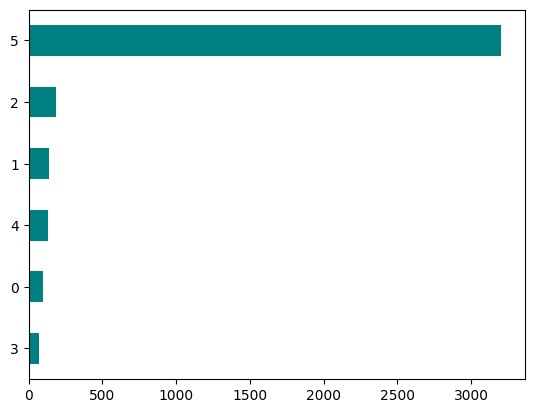

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#объединим два фрейма данных для лучшей визуализации
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #название показателей
print(featureScores.nlargest(11,'Score'))

feature_importances = pd.Series(featureScores['Score'])
feature_importances = feature_importances.sort_values(ascending=True)
feature_importances.plot(kind='barh', color='teal')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# разбиваем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.drop('Категория', axis=1), df['Категория'], test_size=0.3,random_state=42)

# создаем список признаков
col_list = X_train.select_dtypes(include=['number']).columns
print(col_list)
print(X_train.shape, y_train.shape)

Index(['Engine_Size', 'Cylinders', 'Fuel_Consumption_in_City(L/100 km)',
       'Fuel_Consumption_in_City_Hwy(L/100 km)',
       'Fuel_Consumption_comb(L/100km)', 'CO2_Emissions'],
      dtype='object')
(654, 6) (654,)


In [19]:
# вычисляем AUC для модели с одним признаком,
# используя перекрестную проверку
log = LogisticRegression(solver='liblinear')
auc=cross_val_score(log, X_train, y_train, cv=5, scoring='roc_auc')

# превращаем список со значениями AUC в серию
auc_values = pd.Series(auc)
print(auc_values)

0    0.741734
1    0.799729
2    0.778591
3    0.828997
4    0.777199
dtype: float64


In [20]:
# сортируем по убыванию
auc_values = auc_values.sort_values(ascending=False)
auc_values

3    0.828997
1    0.799729
2    0.778591
4    0.777199
0    0.741734
dtype: float64

In [21]:
# формитруем датасет только из информативных показателей
x_1=X.iloc[:,auc_values.index]#3
x_1

,Fuel_Consumption_in_City_Hwy(L/100 km),Cylinders,Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_comb(L/100km),Engine_Size
0,7.0,4,9.9,8.6,2.4
1,10.8,6,11.1,11.0,3.5
2,8.6,4,11.0,9.9,2.0
3,9.1,4,11.3,10.3,2.0
4,8.0,4,11.2,9.8,2.0
...,...,...,...,...,...
930,7.7,4,10.7,9.4,2.0
931,8.3,4,11.1,9.9,2.0
932,8.6,4,11.7,10.3,2.0
933,8.4,4,11.5,10.1,2.0


## Рекурсивное исключение признаков

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

threshold = 5 # the number of most relevant features

lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42, n_jobs=-1, max_iter=1000)

rfe = RFE(lr, n_features_to_select=5)
rfe=rfe.fit(X, y)
# X_train, y_train - входные и выходные данные с обучающей выборки соответственно.
selector_ind = rfe.get_support()
df_rfe = X.iloc[:, selector_ind]
print(df_rfe.columns)

Index(['Engine_Size', 'Cylinders', 'Fuel_Consumption_in_City(L/100 km)',
       'Fuel_Consumption_in_City_Hwy(L/100 km)',
       'Fuel_Consumption_comb(L/100km)'],
      dtype='object')


In [23]:
# Теперь вычислим важности признаков на основе информационного выигрыша.
from lightgbm import LGBMClassifier
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate)

# создаем экземляр класса LGBMClassifier
model_all_features = LGBMClassifier(
    random_state=42, learning_rate=0.01,
    n_estimators=300, bagging_fraction=0.5,
    feature_fraction=1, lambda_l1=10,
    importance_type='gain')

# выполняем перекрестную проверку и сохраняем результат
# с помощью функции cross_validate()
output = cross_validate(
    model_all_features, X_train, y_train, cv=5,
    scoring='roc_auc', return_estimator=True)

# создаем список fi, в который будем сохранять
# важности признаков, и сохраняем в него важности,
# рассчитанные для каждой из моделей
fi = []
for estimator in output['estimator']:
    fi.append(estimator.feature_importances_)

# преобразовываем список в датафрейм, индексы в котором
# будут именами наших переменных
fi = pd.DataFrame(
    np.array(fi).T,
    columns=['importance ' + str(idx)
             for idx in range(len(fi))],
    index=X_train.columns)
# вычисляем усредненные важности и добавляем столбец с ними
fi['mean_importance'] = fi.mean(axis=1)
# смотрим полученный датафрейм
fi

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 359, number of negative: 164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
Engine_Size,58.347469,166.772145,236.445644,177.950520,144.819036,156.866963
Cylinders,747.805121,643.572031,1726.838173,1221.282158,2111.534053,1290.206307
Fuel_Consumption_in_City(L/100 km),3019.119679,2664.345446,2485.384401,2724.021078,2305.757653,2639.725651
Fuel_Consumption_in_City_Hwy(L/100 km),60.186748,155.431564,1.575997,1.293842,17.463314,47.190293
Fuel_Consumption_comb(L/100km),0.000000,22.142407,33.301299,5.726219,26.341929,17.502371
CO2_Emissions,1145.705791,1038.311168,574.795841,202.054617,287.103085,649.594101


# Итоговая выборка

In [30]:
X=df.iloc[:,:4]
X

,Engine_Size,Cylinders,Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_in_City_Hwy(L/100 km)
0,2.4,4,9.9,7.0
1,3.5,6,11.1,10.8
2,2.0,4,11.0,8.6
3,2.0,4,11.3,9.1
4,2.0,4,11.2,8.0
...,...,...,...,...
930,2.0,4,10.7,7.7
931,2.0,4,11.1,8.3
932,2.0,4,11.7,8.6
933,2.0,4,11.5,8.4
